`conda activate imgpro`

# Coding Directions Analysis

Compute and visualize coding directions


# 1. Imports and Configuration

In [136]:
import sys
import os
import glob
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import matplotlib
from typing import Tuple, Optional, Literal, Dict, Any, List
from dataclasses import dataclass
from scipy import stats

%matplotlib widget

# Configure matplotlib
font = {'family': 'Arial', 'weight': 'normal', 'size': 20}
matplotlib.rc('font', **font)

# ============================================================================
# CONFIGURATION - Edit these parameters
# ============================================================================

@dataclass
class Config:
    """Configuration for coding direction analysis."""
    # Data path
    data_path: str = r'D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001'
    
    # Timing parameters
    fps: float = 1 / 0.533
    bin_factor: int = 2
    
    # Epoch windows (frame indices)
    baseline_window: Tuple[int, int] = (10, 60)
    pre_window: Tuple[int, int] = (82, 123)
    post_window: Tuple[int, int] = (141, 181)
    
    # Preprocessing
    rfp_thresh: float = 50  # RFP intensity threshold for mask
    keep_width: Tuple[int, int] = (25, 228)  # X-range to keep
    zero_prob_thresh: float = 1 # in percent, masks voxels that are zero more than this percent of timepoints. registered data has regions of the worm cut off that are inside the mask and vary across z-planes and recording

    # Analysis options
    top_n_voxels: Optional[int] = 10000  # None = use all voxels, int = use top N most variable
    preprocess_method: Literal['raw', 'zscore', 'center'] = 'raw'  # 'raw' = R/R0, 'zscore', 'center' = mean-centered

config = Config()
print(f"Data path: {config.data_path}")
print(f"Preprocessing: {config.preprocess_method}")
print(f"Top N voxels: {config.top_n_voxels or 'all'}")

Data path: D:\DATA\g5ht-free\20251028\date-20251028_time-1500_strain-ISg5HT_condition-starvedpatch_worm001
Preprocessing: raw
Top N voxels: 10000


# 2. Function Definitions

In [137]:
# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_data(config: Config) -> Dict[str, np.ndarray]:
    """
    Load all required data files.
    
    Returns:
        Dictionary with keys: 'g5', 'mask', 'rfp_mean', 'roi', 'z_with_roi'
    """
    pth = config.data_path
    
    # Load ROI
    roi = tifffile.imread(os.path.join(pth, 'roi.tif'))
    
    # Load normalized voxels (R/R0)
    g5 = np.load(os.path.join(pth, 'normalized_voxels.npy'))
    
    # Load and bin mask
    fixed_mask_fn = glob.glob(os.path.join(pth, 'fixed_mask_*.tif'))[0]
    mask = tifffile.imread(fixed_mask_fn)
    h, w = mask.shape
    h_binned = h // config.bin_factor
    w_binned = w // config.bin_factor
    mask = mask.reshape(h_binned, config.bin_factor, w_binned, config.bin_factor).max(axis=(1, 3))
    
    # Repeat mask to match g5 z-dimension
    mask = np.repeat(mask[np.newaxis, :, :], g5.shape[1], axis=0)
    
    # Load RFP mean
    rfp_mean = np.load(os.path.join(pth, 'rfp_mean.npy'))
    
    # Find z-slices with ROI labels
    z_with_roi = np.where(np.sum(roi, axis=(1, 2)) > 0)[0]
    
    print(f"Loaded data shapes:")
    print(f"  ROI: {roi.shape}")
    print(f"  g5 (R/R0): {g5.shape}")
    print(f"  mask: {mask.shape}")
    print(f"  rfp_mean: {rfp_mean.shape}")
    print(f"  Z slices with ROI: {z_with_roi}")
    
    return {
        'g5': g5,
        'mask': mask,
        'rfp_mean': rfp_mean,
        'roi': roi,
        'z_with_roi': z_with_roi
    }


def preprocess_data(data: Dict[str, np.ndarray], config: Config) -> Dict[str, np.ndarray]:
    """
    Preprocess data: subsample z-slices, apply mask, trim width.
    
    Returns:
        Dictionary with preprocessed 'g5', 'mask_updated', 'z_with_roi'
    """
    g5 = data['g5'].copy()
    mask = data['mask'].copy()
    rfp_mean = data['rfp_mean'].copy()
    z_with_roi = data['z_with_roi']
    
    # Subsample z-slices to those with ROI
    g5 = g5[:, z_with_roi, :, :]
    mask = mask[z_with_roi, :, :]
    rfp_mean = rfp_mean[z_with_roi, :, :]
    
    # Update mask based on RFP threshold
    mask_updated = mask.copy()
    mask_updated[rfp_mean < config.rfp_thresh] = 0

    # Update mask based on zero probability threshold
    # Remove voxels that are zero more than zero_prob_threshold% of the time
    # First apply mask to g5 before computing zero probability (so we only count zeros within the mask)
    g5_masked = g5 * mask[np.newaxis, :, :, :]
    zero_mask = (g5_masked == 0)  # Shape: (T, Z, H, W)
    zero_prob = np.mean(zero_mask, axis=0)  # Shape: (Z, H, W), fraction (0-1)
    # Set zero probability to NaN for voxels outside the worm mask
    zero_prob[mask == 0] = np.nan
    
    # Create a mask for voxels that are good (zero less than threshold fraction of time)
    good_voxel_mask = zero_prob < (config.zero_prob_thresh / 100)  # Convert threshold from percent to fraction
    
    # Update the mask to exclude bad voxels
    mask_updated = mask_updated & good_voxel_mask
    
    print(f"  Removed {np.sum(~good_voxel_mask & (mask > 0))} voxels with >{config.zero_prob_thresh}% zeros")
    # Apply mask to g5
    g5 = g5 * mask_updated[np.newaxis, :, :]
    
    # Trim width
    g5 = g5[:, :, :, config.keep_width[0]:config.keep_width[1]]
    mask_updated = mask_updated[:, :, config.keep_width[0]:config.keep_width[1]]
    
    print(f"\nPreprocessed data:")
    print(f"  g5: {g5.shape}")
    print(f"  mask_updated: {mask_updated.shape}")
    print(f"  Number of voxels in mask: {np.sum(mask_updated > 0)}")
    
    return {
        'g5': g5,
        'mask_updated': mask_updated,
        'z_with_roi': z_with_roi
    }


# ============================================================================
# VOXEL SELECTION AND PREPROCESSING FUNCTIONS
# ============================================================================

def flatten_and_mask(g5: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Flatten 4D g5 to 2D (time, voxels) and apply mask.
    
    Args:
        g5: 4D array (time, z, h, w)
        mask: 3D array (z, h, w)
    
    Returns:
        g5_flat: 2D array (time, n_valid_voxels)
        mask_flat: 1D boolean array indicating valid voxel positions
    """
    g5_flat = g5.reshape(g5.shape[0], -1)
    mask_flat = mask.reshape(-1) > 0
    g5_masked = g5_flat[:, mask_flat]
    return g5_masked, mask_flat


def select_top_n_voxels(g5_flat: np.ndarray, n: Optional[int] = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Select top N most variable voxels.
    
    Args:
        g5_flat: 2D array (time, voxels)
        n: Number of top voxels to keep (None = keep all)
    
    Returns:
        g5_selected: 2D array with selected voxels
        sort_indices: Indices of selected voxels (sorted by variance, descending)
    """
    voxel_vars = np.var(g5_flat, axis=0)
    sort_indices = np.argsort(voxel_vars)[::-1]  # Descending
    
    if n is not None and n < len(sort_indices):
        sort_indices = sort_indices[:n]
        print(f"  Selected top {n} most variable voxels")
    else:
        print(f"  Using all {len(sort_indices)} voxels")
    
    return g5_flat[:, sort_indices], sort_indices


def apply_preprocessing(g5: np.ndarray, method: str = 'raw') -> np.ndarray:
    """
    Apply preprocessing to data.
    
    Args:
        g5: 2D array (time, voxels)
        method: 'raw' (R/R0), 'zscore', or 'center' (mean-centered)
    
    Returns:
        Preprocessed data
    """
    if method == 'raw':
        print(f"  Preprocessing: raw (R/R0)")
        return g5
    elif method == 'zscore':
        print(f"  Preprocessing: z-score")
        # Z-score each voxel independently
        mean = np.mean(g5, axis=0, keepdims=True)
        std = np.std(g5, axis=0, keepdims=True)
        std[std == 0] = 1  # Avoid division by zero
        return (g5 - mean) / std
    elif method == 'center':
        print(f"  Preprocessing: mean-centered")
        mean = np.mean(g5, axis=0, keepdims=True)
        return g5 - mean
    else:
        raise ValueError(f"Unknown preprocessing method: {method}")


# ============================================================================
# CODING DIRECTION FUNCTIONS
# ============================================================================

def compute_epoch_means(g5: np.ndarray, baseline_window: Tuple[int, int],
                        pre_window: Tuple[int, int], post_window: Tuple[int, int]) -> Dict[str, np.ndarray]:
    """
    Compute mean activity in each epoch window.
    
    Args:
        g5: 4D array (time, z, h, w) or 2D array (time, voxels)
    
    Returns:
        Dictionary with 'baseline', 'pre', 'post' means
    """
    base_mean = np.mean(g5[baseline_window[0]:baseline_window[1]], axis=0)
    pre_mean = np.mean(g5[pre_window[0]:pre_window[1]], axis=0)
    post_mean = np.mean(g5[post_window[0]:post_window[1]], axis=0)
    
    return {'baseline': base_mean, 'pre': pre_mean, 'post': post_mean}


def compute_coding_directions(epoch_means: Dict[str, np.ndarray], 
                               orthogonalize: bool = False) -> Dict[str, np.ndarray]:
    """
    Compute coding directions from epoch means.
    
    Args:
        epoch_means: Dictionary with 'baseline', 'pre', 'post' means
        orthogonalize: Whether to orthogonalize directions using Gram-Schmidt
    
    Returns:
        Dictionary with 'pre', 'post', 'encounter' coding directions (L2 normalized)
    """
    base = epoch_means['baseline'].flatten()
    pre = epoch_means['pre'].flatten()
    post = epoch_means['post'].flatten()
    
    # Pre-encounter: pre - baseline
    pre_dir = pre - base
    pre_norm = np.linalg.norm(pre_dir)
    if pre_norm > 0:
        pre_dir = pre_dir / pre_norm
    
    # Post-encounter: post - baseline
    post_dir = post - base
    post_norm = np.linalg.norm(post_dir)
    if post_norm > 0:
        post_dir = post_dir / post_norm
    
    # Encounter: post - pre
    enc_dir = post - pre
    enc_norm = np.linalg.norm(enc_dir)
    if enc_norm > 0:
        enc_dir = enc_dir / enc_norm
    
    if orthogonalize:
        # Gram-Schmidt orthogonalization
        # use the gschmidt function defined below
        V = np.column_stack((pre_dir, post_dir, enc_dir))
        Q, R = gschmidt(V)
        pre_dir = Q[:, 0]
        post_dir = Q[:, 1]
        enc_dir = Q[:, 2]
        
        # # Keep pre as-is, orthogonalize post to pre, then encounter to both
        # post_dir = post_dir - np.dot(post_dir, pre_dir) * pre_dir
        # post_norm = np.linalg.norm(post_dir)
        # if post_norm > 0:
        #     post_dir = post_dir / post_norm
        
        # enc_dir = enc_dir - np.dot(enc_dir, pre_dir) * pre_dir
        # enc_dir = enc_dir - np.dot(enc_dir, post_dir) * post_dir
        # enc_norm = np.linalg.norm(enc_dir)
        # if enc_norm > 0:
        #     enc_dir = enc_dir / enc_norm
        
        print("  Applied Gram-Schmidt orthogonalization")
    
    # Compute cosine similarities
    cos_pre_post = np.dot(pre_dir, post_dir)
    cos_pre_enc = np.dot(pre_dir, enc_dir)
    cos_post_enc = np.dot(post_dir, enc_dir)
    
    print(f"  Coding direction cosine similarities:")
    print(f"    pre-post: {cos_pre_post:.4f}")
    print(f"    pre-encounter: {cos_pre_enc:.4f}")
    print(f"    post-encounter: {cos_post_enc:.4f}")
    
    return {
        'pre': pre_dir,
        'post': post_dir,
        'encounter': enc_dir,
        'similarities': {'pre_post': cos_pre_post, 'pre_enc': cos_pre_enc, 'post_enc': cos_post_enc}
    }

def gschmidt(V):
    """
    Gram–Schmidt orthogonalization.

    Parameters
    ----------
    V : (m, n) array_like
        Input matrix (assumed full column rank for stable behavior).

    Returns
    -------
    Q : (m, n) ndarray
        Matrix with orthonormal columns.
    R : (n, n) ndarray
        Upper-triangular matrix such that V = Q @ R.
    """
    V = np.asarray(V, dtype=float)
    m, n = V.shape

    Q = np.zeros((m, n), dtype=V.dtype)
    R = np.zeros((n, n), dtype=V.dtype)

    # First column
    R[0, 0] = np.linalg.norm(V[:, 0])
    if R[0, 0] == 0:
        raise ValueError("First column has zero norm; cannot normalize.")
    Q[:, 0] = V[:, 0] / R[0, 0]

    # Remaining columns
    for k in range(1, n):
        # Projection coefficients onto existing Q columns
        R[:k, k] = Q[:, :k].T @ V[:, k]

        # Subtract projection
        Q[:, k] = V[:, k] - Q[:, :k] @ R[:k, k]

        # Normalize
        R[k, k] = np.linalg.norm(Q[:, k])
        if R[k, k] == 0:
            raise ValueError(f"Column {k} became zero after projection; input may be rank-deficient.")
        Q[:, k] /= R[k, k]

    return Q, R


# ============================================================================
# PROJECTION AND VARIANCE EXPLAINED FUNCTIONS
# ============================================================================

def project_onto_directions(g5_flat: np.ndarray, directions: Dict[str, np.ndarray],
                            mask_flat: np.ndarray) -> Dict[str, np.ndarray]:
    """
    Project data onto coding directions.
    
    Args:
        g5_flat: 2D array (time, all_voxels)
        directions: Dictionary with coding direction vectors
        mask_flat: Boolean mask for valid voxels
    
    Returns:
        Dictionary with projection time series for each direction
    """
    g5_masked = g5_flat[:, mask_flat]
    
    projections = {}
    for name in ['pre', 'post', 'encounter']:
        dir_masked = directions[name][mask_flat]
        proj = np.dot(g5_masked, dir_masked)
        projections[name] = proj
    
    return projections


def normalize_projections(projections: Dict[str, np.ndarray], 
                          method: str = 'minmax') -> Dict[str, np.ndarray]:
    """
    Normalize projection time series.
    
    Args:
        projections: Dictionary with raw projections
        method: 'minmax' (0-1), 'zscore', or 'none'
    
    Returns:
        Normalized projections
    """
    normalized = {}
    for name, proj in projections.items():
        if method == 'minmax':
            pmin, pmax = proj.min(), proj.max()
            if pmax > pmin:
                normalized[name] = (proj - pmin) / (pmax - pmin)
            else:
                normalized[name] = np.zeros_like(proj)
        elif method == 'zscore':
            mean, std = proj.mean(), proj.std()
            if std > 0:
                normalized[name] = (proj - mean) / std
            else:
                normalized[name] = np.zeros_like(proj)
        else:
            normalized[name] = proj
    
    return normalized


def compute_variance_explained(g5_flat: np.ndarray, directions: Dict[str, np.ndarray],
                                mask_flat: np.ndarray) -> Dict[str, float]:
    """
    Compute fraction of total variance explained by each coding direction.
    
    Args:
        g5_flat: 2D array (time, all_voxels)
        directions: Dictionary with coding direction vectors
        mask_flat: Boolean mask for valid voxels
    
    Returns:
        Dictionary with variance explained (0-1) for each direction
    """
    g5_masked = g5_flat[:, mask_flat]
    
    # Total variance = sum of variance across all voxels
    voxel_vars = np.var(g5_masked, axis=0)
    total_var = np.sum(voxel_vars)
    
    if total_var == 0:
        return {'pre': 0.0, 'post': 0.0, 'encounter': 0.0, 'total': 0.0}
    
    var_explained = {}
    for name in ['pre', 'post', 'encounter']:
        dir_masked = directions[name][mask_flat]
        proj = np.dot(g5_masked, dir_masked)
        var_explained[name] = float(np.clip(np.var(proj) / total_var, 0.0, 1.0))
    
    var_explained['total'] = total_var
    
    return var_explained


def compute_epoch_stats(g5_flat: np.ndarray, config: Config) -> Dict[str, Dict[str, float]]:
    """
    Compute statistics for each epoch.
    
    Returns:
        Dictionary with mean, std, min, max for each epoch
    """
    epochs = {
        'baseline': g5_flat[config.baseline_window[0]:config.baseline_window[1]],
        'pre': g5_flat[config.pre_window[0]:config.pre_window[1]],
        'post': g5_flat[config.post_window[0]:config.post_window[1]]
    }
    
    stats_dict = {}
    for name, data in epochs.items():
        flat = data.flatten()
        stats_dict[name] = {
            'mean': float(np.mean(flat)),
            'std': float(np.std(flat)),
            'min': float(np.min(flat)),
            'max': float(np.max(flat))
        }
    
    return stats_dict

In [214]:
# ============================================================================
# PLOTTING FUNCTIONS
# ============================================================================

def get_centered_clim(data: np.ndarray, mask: Optional[np.ndarray] = None) -> Tuple[float, float]:
    """
    Get symmetric color limits centered on 0 for diverging colormaps.
    
    Args:
        data: Array of values
        mask: Optional boolean mask for valid values
    
    Returns:
        (vmin, vmax) symmetric around 0
    """
    if mask is not None:
        valid_data = data[mask > 0]
    else:
        valid_data = data.flatten()
    
    # Remove NaNs
    valid_data = valid_data[~np.isnan(valid_data)]
    
    if len(valid_data) == 0:
        return (-1, 1)
    
    min = np.min(valid_data)
    max = np.max(valid_data)
    custom_norm=matplotlib.colors.TwoSlopeNorm(vmin=min, vcenter=0., vmax=max)
    return min, max, custom_norm
    # abs_min = np.min(np.abs(valid_data))
    # return (-abs_min, abs_min)


def plot_representative_slices(g5: np.ndarray, z_with_roi: np.ndarray, mask: np.ndarray,
                                frame: int, title: str = "Activity"):
    """Plot representative z-slices for a given frame."""
    n_z = g5.shape[1]
    slice_indices = [0, n_z // 2, n_z - 1] if n_z >= 3 else list(range(n_z))
    # slice_indices = np.arange(0,n_z, 2)
    
    fig, axs = plt.subplots(1, len(slice_indices), figsize=(5 * len(slice_indices), 4), 
                            constrained_layout=True)
    if len(slice_indices) == 1:
        axs = [axs]
    
    for i, slice_idx in enumerate(slice_indices):
        ax = axs[i]
        im = ax.imshow(g5[frame, slice_idx], cmap='viridis')
        # plot mask contours (levels=[0.5] draws boundary between 0 and non-zero)
        ax.contour(mask[slice_idx].astype(float), colors='white', linewidths=0.5, levels=[0.5])
        ax.set_title(f'z {z_with_roi[slice_idx]}')
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=13)
        ax.axis('off')
    
    fig.suptitle(f'{title} (frame {frame})', y=0.95)
    return fig


def plot_voxel_heatmap(g5_flat: np.ndarray, fps: float, time_window: Optional[Tuple[int, int]] = None,
                       max_voxels: int = 50000, vmin: float = 0.8, vmax: float = 6.5):
    """Plot heatmap of voxel activity over time."""
    # Optionally subset time window
    if time_window is not None:
        g5_subset = g5_flat[time_window[0]:time_window[1]]
        time_offset = time_window[0]
    else:
        g5_subset = g5_flat
        time_offset = 0
    
    # Sort by variance and limit voxels
    voxel_vars = np.var(g5_subset, axis=0)
    sort_idx = np.argsort(voxel_vars)[::-1]
    n_show = min(max_voxels, g5_subset.shape[1])
    g5_sorted = g5_subset[:, sort_idx[:n_show]]
    
    time = (np.arange(g5_subset.shape[0]) + time_offset) / fps
    voxel_indices = np.arange(n_show)
    
    fig, ax = plt.subplots(figsize=(5, 7), constrained_layout=True)
    im = ax.pcolormesh(time, voxel_indices, g5_sorted.T, shading='auto', 
                       cmap='plasma', vmin=vmin, vmax=vmax)
    ax.invert_yaxis()
    ax.set_xlabel('Time (s)')
    ax.set_ylabel(f'Voxels (top {n_show} by variance)')
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('R/R0', rotation=270, labelpad=15)
    
    return fig


def plot_mean_activity(g5_flat: np.ndarray, fps: float, config: Config):
    """Plot mean activity over time with epoch markers."""
    mean_activity = np.mean(g5_flat, axis=1)
    time = np.arange(len(mean_activity)) / fps
    
    fig, ax = plt.subplots(figsize=(8, 3.5), constrained_layout=True)
    ax.plot(time, mean_activity, lw=1.5, color='black')
    ax.axhline(1, color='gray', ls='--', alpha=0.5)
    
    # Shade epochs
    epochs = [
        (config.baseline_window, 'gray', 'Baseline', 0.2),
        (config.pre_window, 'gray', 'Pre-encounter', 0.2),
        (config.post_window, 'gray', 'Post-encounter', 0.2)
    ]
    for (start, end), color, label, alpha in epochs:
        ax.axvspan(start / fps, end / fps, alpha=alpha, color=color, label=label)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean R/R0')
    # ax.legend(loc='upper right', fontsize=11)
    
    return fig

class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        v_ext = np.max( [ np.abs(self.vmin), np.abs(self.vmax) ] )
        x, y = [-v_ext, self.midpoint, v_ext], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_coding_directions_spatial(directions: Dict[str, np.ndarray], mask: np.ndarray,
                                    z_with_roi: np.ndarray, shape: Tuple[int, ...], slice_indices=None, cmap='RdBu_r', contour_color='black'):
    """Plot spatial distribution of coding direction weights (centered on 0)."""
    n_z = shape[0]
    if slice_indices==None:
        slice_indices = [0, n_z // 2, n_z - 1] if n_z >= 3 else list(range(n_z))
    
    dir_names = ['pre', 'post', 'encounter']
    titles = ['Pre-encounter', 'Post-encounter', 'Encounter']
    
    fig, axs = plt.subplots(len(dir_names), len(slice_indices), 
                            figsize=(5 * len(slice_indices), 4 * len(dir_names)),
                            constrained_layout=True)
    
    for row, (dir_name, title) in enumerate(zip(dir_names, titles)):
        dir_reshaped = directions[dir_name].reshape(shape)
        dir_masked = dir_reshaped * mask
        
        # Get symmetric limits centered on 0
        # min, max, norm = get_centered_clim(dir_masked, mask)
        # # Get limits based on percentiles
        # vmin = np.percentile(dir_masked, 1)
        # vmax = np.percentile(dir_masked, 100)
        norm = MidpointNormalize(midpoint=0)
        
        for col, slice_idx in enumerate(slice_indices):
            ax = axs[row, col] if len(dir_names) > 1 else axs[col]
            im = ax.imshow(dir_masked[slice_idx], cmap=cmap, norm=norm)
            # plot mask contours
            ax.contour(mask[slice_idx], colors=contour_color, linewidths=0.5, levels=[0.5])
            ax.set_title(f'{title} - z{z_with_roi[slice_idx]}')
            cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
            cbar.ax.tick_params(labelsize=13)
            ax.axis('off')
    
    return fig


def plot_projections(projections: Dict[str, np.ndarray], fps: float, config: Config,
                     normalized: bool = True):
    """Plot projection time series for all coding directions."""
    time = np.arange(len(projections['pre'])) / fps
    
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
    
    colors = {'pre': 'tab:blue', 'post': 'tab:orange', 'encounter': 'tab:green'}
    labels = {'pre': 'Pre-encounter', 'post': 'Post-encounter', 'encounter': 'Encounter'}
    
    # for name in ['pre', 'post', 'encounter']:
    for name in ['pre', 'post']:
        ax.plot(time, projections[name], lw=1.5, color=colors[name], label=labels[name])
    
    # Shade epochs
    epochs = [
        (config.baseline_window, 'gray', 0.1),
        (config.pre_window, 'gray', 0.1),
        (config.post_window, 'gray', 0.1)
    ]
    for (start, end), color, alpha in epochs:
        ax.axvspan(start / fps, end / fps, alpha=alpha, color=color)
    
    ax.set_xlabel('Time (s)')
    ylabel = 'Projection (normalized)' if normalized else 'Projection'
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    
    return fig


def plot_variance_explained(var_explained: Dict[str, float]):
    """Plot variance explained bar chart."""
    names = ['Pre-encounter', 'Post-encounter', 'Encounter']
    values = [var_explained['pre'] * 100, var_explained['post'] * 100, 
              var_explained['encounter'] * 100]
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    
    fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
    bars = ax.bar(names, values, color=colors, edgecolor='black', linewidth=1)
    # rotate x-tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', fontsize=16)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.2f}%', ha='center', va='bottom', fontsize=11)
    
    ax.set_ylabel('Variance explained (%)')
    ax.set_ylim(0, max(values) * 1.2 if max(values) > 0 else 1)
    
    return fig


def plot_projection_scatter_2d(projections: Dict[str, np.ndarray], config: Config, fps: float):
    """Plot 2D scatter of projections colored by time."""
    time = np.arange(len(projections['pre'])) / fps
    
    fig, axs = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
    
    pairs = [('pre', 'post'), ('pre', 'encounter'), ('post', 'encounter')]
    labels = {'pre': 'Pre-encounter', 'post': 'Post-encounter', 'encounter': 'Encounter'}
    
    for ax, (x_name, y_name) in zip(axs, pairs):
        sc = ax.scatter(projections[x_name], projections[y_name], c=time, 
                       cmap='viridis', s=10, alpha=0.7)
        ax.set_xlabel(labels[x_name])
        ax.set_ylabel(labels[y_name])
        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label('Time (s)')
    
    fig.suptitle('Projection scatter plots (colored by time)')
    return fig


def plot_epoch_distributions(g5_flat: np.ndarray, config: Config):
    """Plot distribution of activity values in each epoch."""
    epochs = {
        'Baseline': g5_flat[config.baseline_window[0]:config.baseline_window[1]].flatten(),
        'Pre-encounter': g5_flat[config.pre_window[0]:config.pre_window[1]].flatten(),
        'Post-encounter': g5_flat[config.post_window[0]:config.post_window[1]].flatten()
    }
    
    fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True)
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    
    for (name, data), color in zip(epochs.items(), colors):
        # Remove zeros (masked values)
        data = data[data != 0]
        ax.hist(data, bins=100, alpha=0.5, label=name, color=color, density=True)
    
    ax.set_xlabel('Activity value')
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_title('Activity distributions by epoch')
    
    return fig


def plot_voxel_weight_distributions(directions: Dict[str, np.ndarray], mask_flat: np.ndarray):
    """Plot distribution of voxel weights in each coding direction."""
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5), constrained_layout=True)
    
    names = ['pre', 'post', 'encounter']
    titles = ['Pre-encounter', 'Post-encounter', 'Encounter']
    colors = ['tab:blue', 'tab:orange', 'tab:green']
    
    for ax, name, title, color in zip(axs, names, titles, colors):
        weights = directions[name][mask_flat]
        ax.hist(weights, bins=100, color=color, alpha=0.7, edgecolor='black', linewidth=0.5)
        ax.axvline(0, color='black', ls='--', alpha=0.5)
        ax.set_xlabel('Weight')
        ax.set_ylabel('Count')
        ax.set_title(f'{title} weights\n(mean={weights.mean():.4f}, std={weights.std():.4f})')
    
    fig.suptitle('Coding direction voxel weight distributions', y=1.02)
    return fig


def plot_coding_direction_similarity_matrix(directions: Dict[str, np.ndarray]):
    """Plot correlation matrix between coding directions (centered on 0)."""
    names = ['pre', 'post', 'encounter']
    labels = ['Pre-encounter', 'Post-encounter', 'Encounter']
    
    # Compute cosine similarity matrix
    sim_matrix = np.zeros((3, 3))
    for i, n1 in enumerate(names):
        for j, n2 in enumerate(names):
            sim_matrix[i, j] = np.dot(directions[n1], directions[n2])
    
    fig, ax = plt.subplots(figsize=(5, 4), constrained_layout=True)
    # Similarity is already in [-1, 1], so this is centered on 0
    im = ax.imshow(sim_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
    
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels)
    
    # Add text annotations
    for i in range(3):
        for j in range(3):
            ax.text(j, i, f'{sim_matrix[i, j]:.3f}', ha='center', va='center', fontsize=10)
    
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Cosine similarity')
    ax.set_title('Coding direction similarity matrix')
    
    return fig


def plot_epoch_mean_comparison(epoch_means: Dict[str, np.ndarray], mask: np.ndarray,
                                z_with_roi: np.ndarray, shape: Tuple[int, ...]):
    """Plot mean activity maps for each epoch."""
    n_z = shape[0]
    mid_slice = n_z // 2
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    
    names = ['baseline', 'pre', 'post']
    titles = ['Baseline', 'Pre-encounter', 'Post-encounter']
    
    # Find global min/max for consistent colorbar
    all_vals = []
    for name in names:
        reshaped = epoch_means[name].reshape(shape)
        masked = reshaped[mid_slice] * mask[mid_slice]
        all_vals.extend(masked[mask[mid_slice] > 0].flatten())
    vmin, vmax = np.percentile(all_vals, [0, 99.5])
    
    for ax, name, title in zip(axs, names, titles):
        reshaped = epoch_means[name].reshape(shape)
        masked = reshaped[mid_slice] * mask[mid_slice]
        im = ax.imshow(masked, cmap='viridis', vmin=vmin, vmax=vmax)
        # plot mask contours
        ax.contour(mask[mid_slice], colors='white', linewidths=0.5, levels=[0.5])
        ax.set_title(f'{title}\n(z{z_with_roi[mid_slice]})')
        ax.axis('off')
        cbar = fig.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=13)
    
    # fig.suptitle('Epoch mean activity (middle z-slice)', y=0.95)
    return fig


# ============================================================================
# RECONSTRUCTION FUNCTIONS
# ============================================================================

def reconstruct_from_directions(projections: Dict[str, np.ndarray], 
                                 directions: Dict[str, np.ndarray],
                                 mask_flat: np.ndarray,
                                 direction_names: List[str] = ['pre', 'post', 'encounter']
                                 ) -> np.ndarray:
    """
    Reconstruct data from projections onto coding directions (masked voxels only).
    
    reconstruction[t] = sum_i (projection_i[t] * direction_i)
    
    Args:
        projections: Dictionary with projection time series
        directions: Dictionary with coding direction vectors (full spatial size)
        mask_flat: Boolean mask for valid voxels
        direction_names: List of direction names to include in reconstruction
    
    Returns:
        Reconstructed data array (time, n_masked_voxels)
    """
    n_time = len(projections[direction_names[0]])
    n_masked_voxels = np.sum(mask_flat)
    
    reconstruction = np.zeros((n_time, n_masked_voxels))
    
    for name in direction_names:
        # Use only masked voxels from direction vector
        dir_masked = directions[name][mask_flat]
        # Outer product: projection (time,) x direction (masked_voxels,) -> (time, masked_voxels)
        reconstruction += np.outer(projections[name], dir_masked)
    
    return reconstruction


def compute_reconstruction_error(original: np.ndarray, reconstruction: np.ndarray,
                                  mask_flat: np.ndarray) -> Dict[str, float]:
    """
    Compute reconstruction error metrics.
    
    Args:
        original: Original data (time, all_voxels)
        reconstruction: Reconstructed data (time, voxels matching mask)
        mask_flat: Boolean mask for valid voxels
    
    Returns:
        Dictionary with error metrics
    """
    original_masked = original[:, mask_flat]
    
    # Mean squared error
    mse = np.mean((original_masked - reconstruction) ** 2)
    
    # Correlation
    orig_flat = original_masked.flatten()
    recon_flat = reconstruction.flatten()
    correlation = np.corrcoef(orig_flat, recon_flat)[0, 1]
    
    # R-squared (variance explained by reconstruction)
    ss_res = np.sum((original_masked - reconstruction) ** 2)
    ss_tot = np.sum((original_masked - np.mean(original_masked)) ** 2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0.0
    
    return {
        'mse': float(mse),
        'rmse': float(np.sqrt(mse)),
        'correlation': float(correlation),
        'r_squared': float(r_squared)
    }


def plot_reconstruction_spatial(original_4d: np.ndarray, reconstruction: np.ndarray,
                                 mask_3d: np.ndarray, mask_flat: np.ndarray,
                                 z_with_roi: np.ndarray, frame: int,
                                 direction_label: str = "All directions"):
    """
    Plot original vs reconstruction for a single frame (spatial comparison).
    
    Args:
        original_4d: Original 4D data (time, z, h, w)
        reconstruction: Reconstructed 2D data (time, masked_voxels)
        mask_3d: 3D mask (z, h, w)
        mask_flat: 1D boolean mask
        z_with_roi: Array of z-slice indices with ROI
        frame: Frame index to visualize
        direction_label: Label for the reconstruction (e.g., "Pre", "All")
    """
    shape = (original_4d.shape[1], original_4d.shape[2], original_4d.shape[3])
    n_z = shape[0]
    slice_indices = [0, n_z // 2, n_z - 1] if n_z >= 3 else list(range(n_z))
    
    # Reshape reconstruction to 3D
    recon_full = np.zeros(np.prod(shape))
    recon_full[mask_flat] = reconstruction[frame]
    recon_3d = recon_full.reshape(shape)
    
    # Original frame
    orig_3d = original_4d[frame]
    
    # Compute residual
    residual_3d = orig_3d - recon_3d
    
    fig, axs = plt.subplots(3, len(slice_indices), 
                            figsize=(4 * len(slice_indices), 10),
                            constrained_layout=True)
    
    # Row labels
    row_labels = ['Original', f'Reconstruction\n({direction_label})', 'Residual']
    
    # Find color limits for original/reconstruction (same scale)
    orig_vals = orig_3d[mask_3d > 0]
    vmin_orig, vmax_orig = np.percentile(orig_vals, [2, 98])
    
    # Symmetric limits for residual (centered on 0)
    vmin_res, vmax_res = get_symmetric_clim(residual_3d, mask_3d)
    
    for col, slice_idx in enumerate(slice_indices):
        # Original
        ax = axs[0, col]
        im = ax.imshow(orig_3d[slice_idx] * mask_3d[slice_idx], cmap='viridis', 
                       vmin=vmin_orig, vmax=vmax_orig)
        ax.set_title(f'z{z_with_roi[slice_idx]}')
        ax.axis('off')
        if col == len(slice_indices) - 1:
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Reconstruction
        ax = axs[1, col]
        im = ax.imshow(recon_3d[slice_idx] * mask_3d[slice_idx], cmap='viridis',
                       vmin=vmin_orig, vmax=vmax_orig)
        ax.axis('off')
        if col == len(slice_indices) - 1:
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Residual (diverging, centered on 0)
        norm = MidpointNormalize(midpoint=0)
        ax = axs[2, col]
        im = ax.imshow(residual_3d[slice_idx] * mask_3d[slice_idx], cmap='RdBu_r',
                       norm=norm)
        ax.axis('off')
        if col == len(slice_indices) - 1:
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Add row labels
    for row, label in enumerate(row_labels):
        axs[row, 0].set_ylabel(label, fontsize=12, rotation=90, labelpad=10)
    
    # fig.suptitle(f'Reconstruction comparison (frame {frame})', fontsize=14, y=0.95)
    return fig


def plot_reconstruction_comparison(original_4d: np.ndarray, 
                                    reconstructions: Dict[str, np.ndarray],
                                    mask_3d: np.ndarray, mask_flat: np.ndarray,
                                    z_with_roi: np.ndarray, frame: int):
    """
    Compare reconstructions from different direction combinations.
    
    Args:
        original_4d: Original 4D data
        reconstructions: Dictionary with reconstruction arrays keyed by label
        mask_3d, mask_flat: Masks
        z_with_roi: Z-slice indices
        frame: Frame to visualize
    """
    shape = (original_4d.shape[1], original_4d.shape[2], original_4d.shape[3])
    mid_slice = shape[0] // 2
    
    n_recons = len(reconstructions)
    fig, axs = plt.subplots(2, n_recons + 1, figsize=(4 * (n_recons + 1), 8),
                            constrained_layout=True)
    
    # Original
    orig_3d = original_4d[frame]
    orig_vals = orig_3d[mask_3d > 0]
    vmin, vmax = np.percentile(orig_vals, [2, 98])
    
    ax = axs[0, 0]
    im = ax.imshow(orig_3d[mid_slice] * mask_3d[mid_slice], cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title('Original')
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Reconstructions
    for i, (label, recon) in enumerate(reconstructions.items()):
        recon_full = np.zeros(np.prod(shape))
        recon_full[mask_flat] = recon[frame]
        recon_3d = recon_full.reshape(shape)
        residual_3d = orig_3d - recon_3d
        
        # Reconstruction
        ax = axs[0, i + 1]
        im = ax.imshow(recon_3d[mid_slice] * mask_3d[mid_slice], cmap='viridis', vmin=vmin, vmax=vmax)
        ax.set_title(f'Recon: {label}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Residual (centered on 0)
        ax = axs[1, i + 1]
        vmin_res, vmax_res = get_symmetric_clim(residual_3d, mask_3d)
        im = ax.imshow(residual_3d[mid_slice] * mask_3d[mid_slice], cmap='RdBu_r', 
                       vmin=vmin_res, vmax=vmax_res)
        ax.set_title(f'Residual: {label}')
        ax.axis('off')
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Empty bottom-left cell
    axs[1, 0].axis('off')
    
    fig.suptitle(f'Reconstruction comparison (frame {frame}, z={z_with_roi[mid_slice]})', 
                 fontsize=14, y=1.01)
    return fig


def plot_reconstruction_timeseries(original_4d: np.ndarray, 
                                    reconstructions: Dict[str, np.ndarray],
                                    mask_flat: np.ndarray, fps: float, config: Config):
    """
    Plot mean activity time series: original vs reconstructions.
    """
    original_masked = original_4d.reshape(original_4d.shape[0], -1)[:, mask_flat]
    orig_mean = np.mean(original_masked, axis=1)
    time = np.arange(len(orig_mean)) / fps
    
    fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
    
    # Original
    ax.plot(time, orig_mean, 'k-', lw=2, label='Original')
    
    # Reconstructions
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
    for i, (label, recon) in enumerate(reconstructions.items()):
        recon_mean = np.mean(recon, axis=1)
        ax.plot(time, recon_mean, color=colors[i % len(colors)], lw=1.5, 
                ls='--', label=f'Recon: {label}')
    
    # Shade epochs
    epochs = [
        (config.baseline_window, 'blue', 0.1),
        (config.pre_window, 'orange', 0.1),
        (config.post_window, 'green', 0.1)
    ]
    for (start, end), color, alpha in epochs:
        ax.axvspan(start / fps, end / fps, alpha=alpha, color=color)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean activity')
    ax.legend(loc='upper right')
    ax.set_title('Mean activity: Original vs Reconstructions')
    
    return fig


# Need to import List for type hints
from typing import List

print("Plotting and reconstruction functions defined.")

Plotting and reconstruction functions defined.


# 3. Load and Preprocess Data

In [139]:
# Load raw data
raw_data = load_data(config)

# Preprocess (apply mask, subset z-slices, trim width)
processed = preprocess_data(raw_data, config)

# Store for later use
g5_4d = processed['g5']  # 4D: (time, z, h, w)
mask_3d = processed['mask_updated']  # 3D: (z, h, w)
z_with_roi = processed['z_with_roi']

print(f"\nData loaded and preprocessed successfully.")

Loaded data shapes:
  ROI: (39, 200, 500)
  g5 (R/R0): (1200, 39, 100, 250)
  mask: (39, 100, 250)
  rfp_mean: (39, 100, 250)
  Z slices with ROI: [ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
  Removed 56595 voxels with >1% zeros

Preprocessed data:
  g5: (1200, 19, 100, 203)
  mask_updated: (19, 100, 203)
  Number of voxels in mask: 144003

Data loaded and preprocessed successfully.


# 4. Flatten, Select Voxels, and Preprocess

In [140]:
# Flatten 4D data to 2D and apply mask
g5_flat_all, mask_flat = flatten_and_mask(g5_4d, mask_3d)
print(f"Flattened data: {g5_flat_all.shape} (time x voxels)")

# Select top N most variable voxels (or all if None)
g5_selected, selected_indices = select_top_n_voxels(g5_flat_all, config.top_n_voxels)
print(f"Selected data: {g5_selected.shape}")

# Apply preprocessing (raw/zscore/center)
g5_preprocessed = apply_preprocessing(g5_selected, config.preprocess_method)

# Store spatial shape for later (for reshaping coding directions)
spatial_shape = (g5_4d.shape[1], g5_4d.shape[2], g5_4d.shape[3])  # (z, h, w)
print(f"\nSpatial shape: {spatial_shape}")

Flattened data: (1200, 144003) (time x voxels)
  Selected top 10000 most variable voxels
Selected data: (1200, 10000)
  Preprocessing: raw (R/R0)

Spatial shape: (19, 100, 203)


# 5. Visualize Raw Data

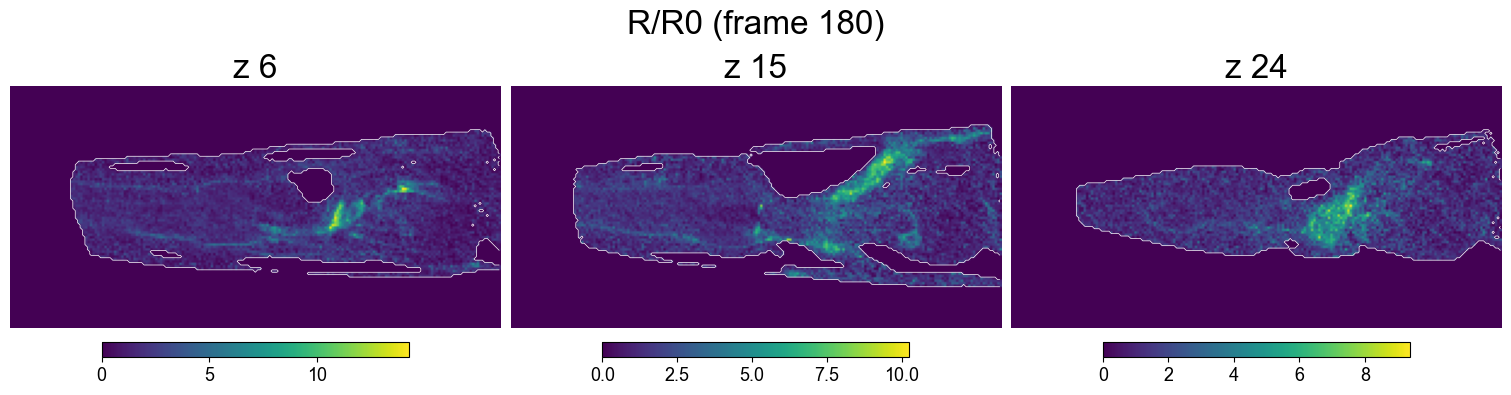

In [141]:
%matplotlib inline
plt.close('all')

# Plot representative z-slices at a chosen frame
frame_to_show = 180
fig1 = plot_representative_slices(g5_4d, z_with_roi, mask_3d, frame=frame_to_show, title="R/R0")
plt.show()

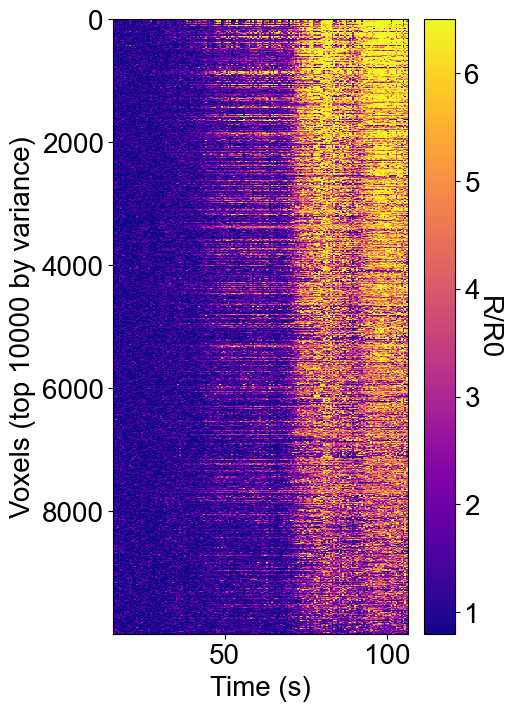

In [142]:
# Plot voxel heatmap over time (for selected voxels)
%matplotlib inline
fig2 = plot_voxel_heatmap(g5_preprocessed, config.fps, time_window=(30,200), max_voxels=config.top_n_voxels)
plt.show()

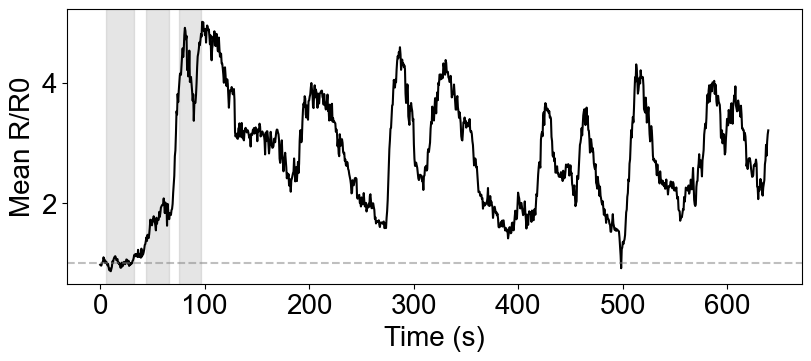

In [143]:
# Plot mean activity over time with epoch markers
fig3 = plot_mean_activity(g5_preprocessed, config.fps, config)
plt.show()

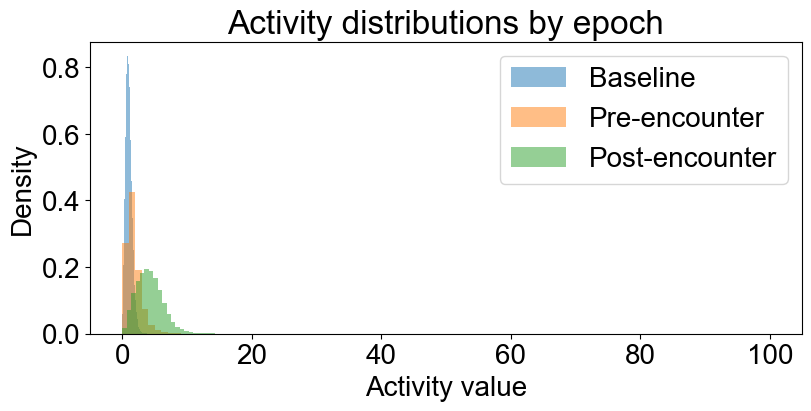

In [144]:
# Plot activity distributions by epoch
fig4 = plot_epoch_distributions(g5_preprocessed, config)
plt.show()

# 6. Compute Coding Directions

In [194]:
# Compute epoch means (using 4D data for spatial info)
epoch_means = compute_epoch_means(g5_4d, config.baseline_window, config.pre_window, config.post_window)

# Compute coding directions (optionally orthogonalize)
coding_directions = compute_coding_directions(epoch_means, orthogonalize=True)

print(f"\nCoding directions computed successfully.")

  Applied Gram-Schmidt orthogonalization
  Coding direction cosine similarities:
    pre-post: 0.0000
    pre-encounter: -0.5962
    post-encounter: 0.7763

Coding directions computed successfully.


# 7. Visualize Coding Directions (Spatial)

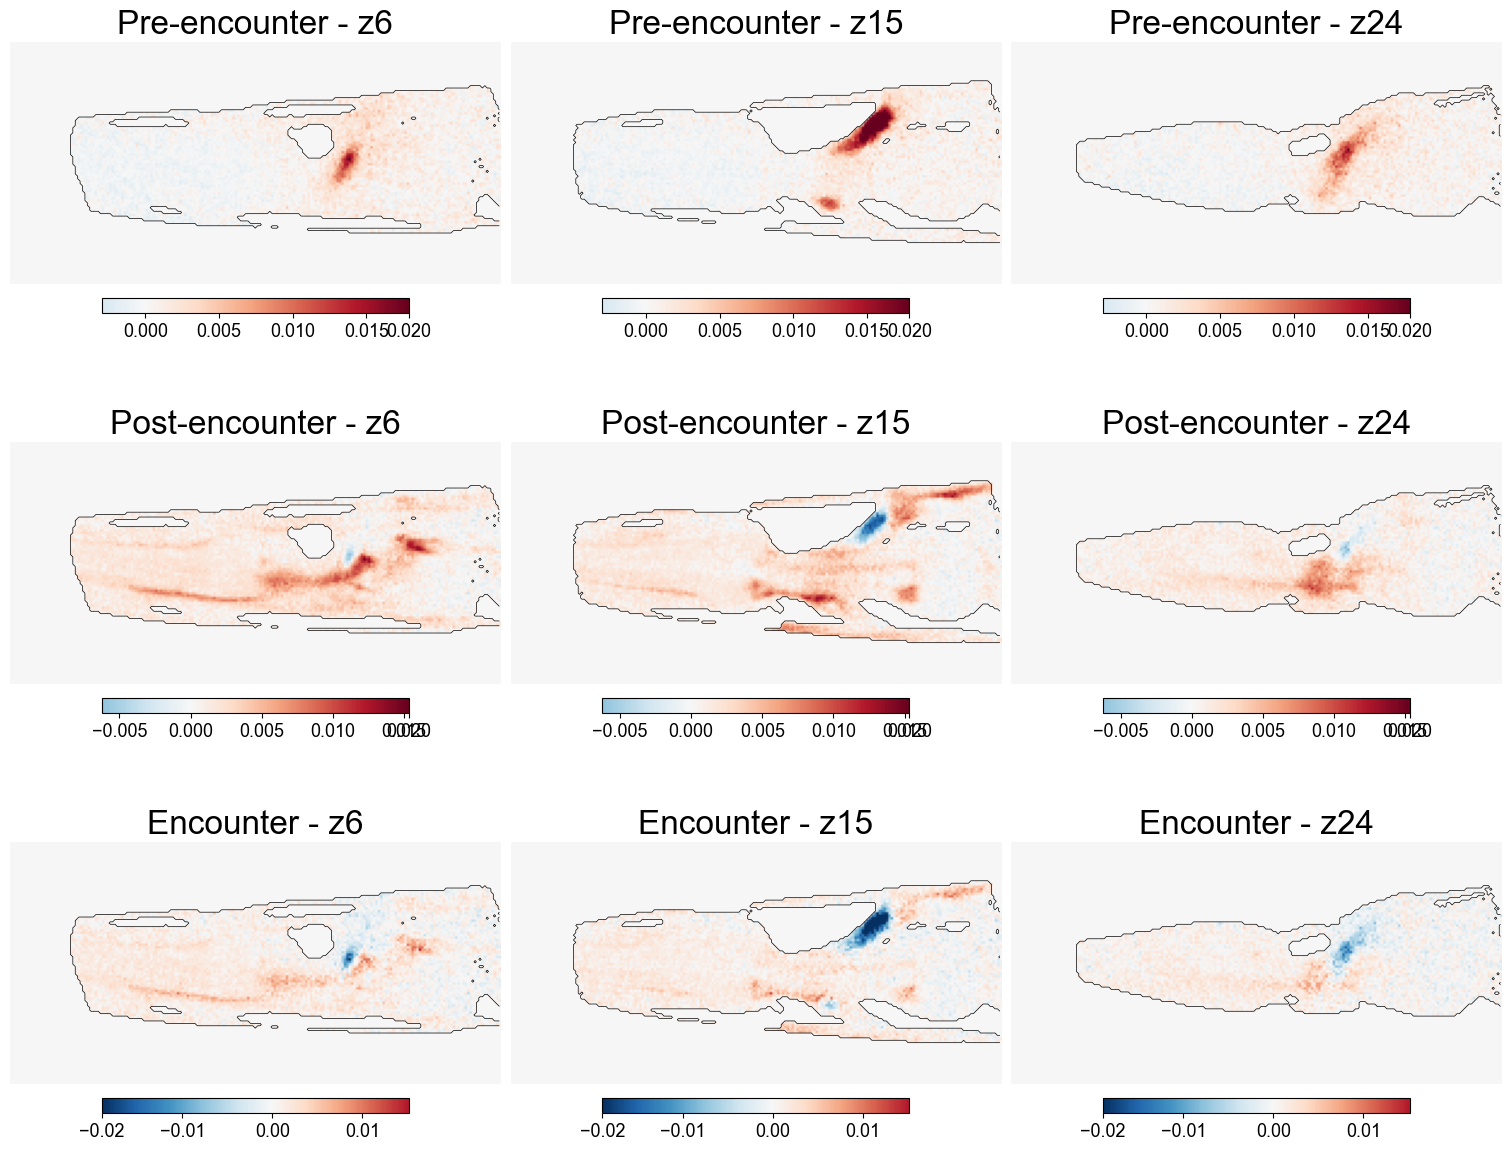

In [195]:
# Plot spatial distribution of coding direction weights
%matplotlib inline
fig5 = plot_coding_directions_spatial(coding_directions, mask_3d, z_with_roi, spatial_shape, cmap="RdBu_r", contour_color = 'black')
plt.show()

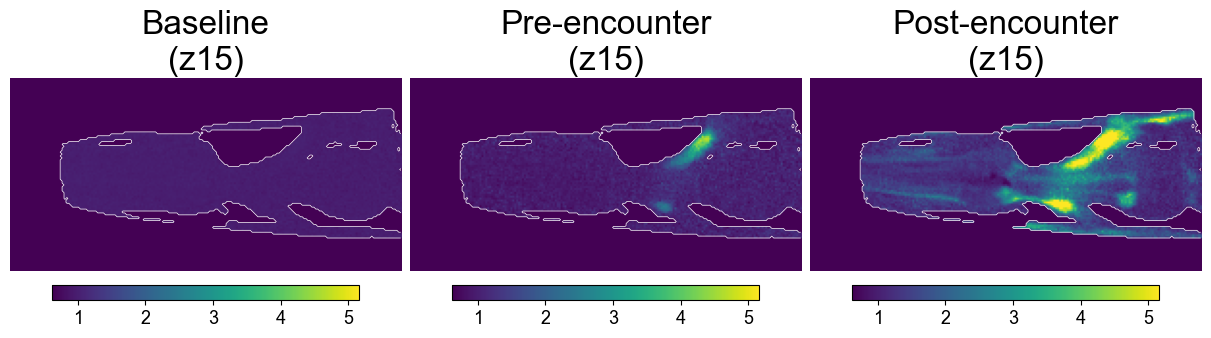

In [196]:
# Plot epoch mean activity maps
fig6 = plot_epoch_mean_comparison(epoch_means, mask_3d, z_with_roi, spatial_shape)
plt.show()

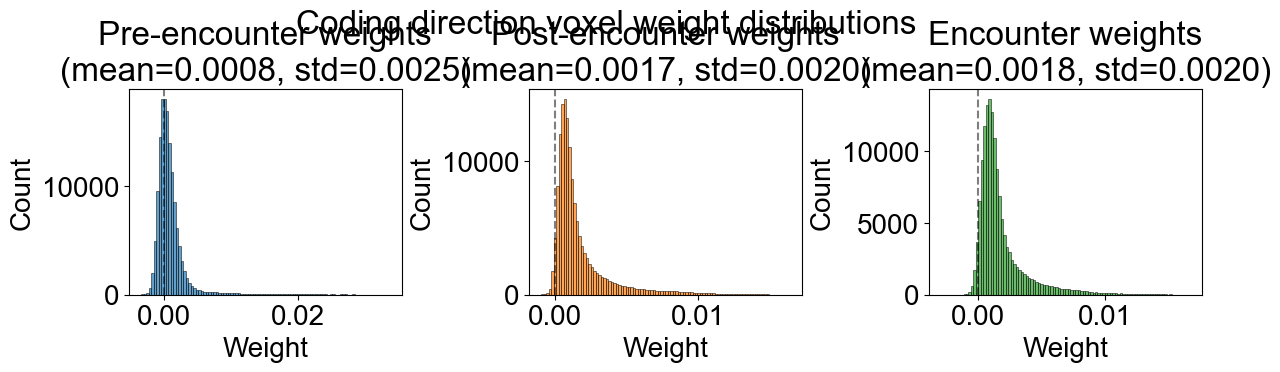

In [109]:
# Plot voxel weight distributions for each coding direction
fig7 = plot_voxel_weight_distributions(coding_directions, mask_flat)
plt.show()

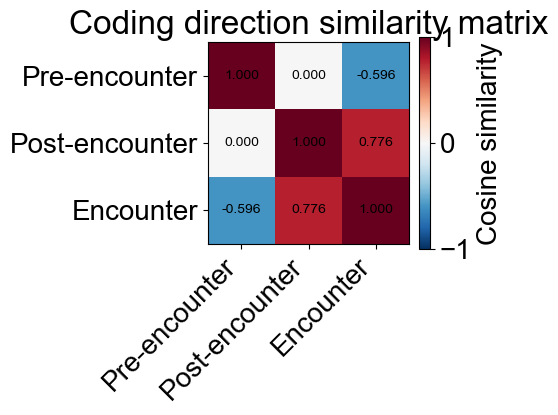

In [197]:
# Plot coding direction similarity matrix
fig8 = plot_coding_direction_similarity_matrix(coding_directions)
plt.show()

# 8. Project Data onto Coding Directions

In [198]:
# Flatten 4D data for projections (use all data, not just selected voxels)
g5_flat_for_proj = g5_4d.reshape(g5_4d.shape[0], -1)

# Project onto coding directions
projections_raw = project_onto_directions(g5_flat_for_proj, coding_directions, mask_flat)

# Normalize projections for visualization
projections_norm = normalize_projections(projections_raw, method='minmax')

print(f"Projection shapes:")
for name, proj in projections_raw.items():
    print(f"  {name}: {proj.shape}")

Projection shapes:
  pre: (1200,)
  post: (1200,)
  encounter: (1200,)


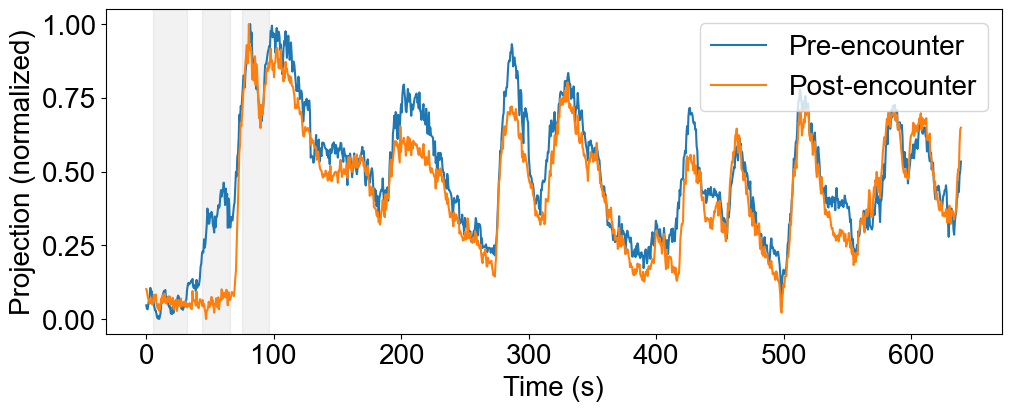

In [207]:
# Plot projection time series
fig9 = plot_projections(projections_norm, config.fps, config, normalized=True)
plt.show()

In [ ]:
# Plot 2D projection scatter (colored by time)
fig10 = plot_projection_scatter_2d(projections_norm, config, config.fps)
plt.show()

# 9. Variance Explained Analysis

In [208]:
# Compute variance explained by each coding direction
var_explained = compute_variance_explained(g5_flat_for_proj, coding_directions, mask_flat)

print(f"\nVariance Explained:")
print(f"  Pre-encounter:  {var_explained['pre']*100:.4f}%")
print(f"  Post-encounter: {var_explained['post']*100:.4f}%")
print(f"  Encounter:      {var_explained['encounter']*100:.4f}%")
print(f"  Total variance: {var_explained['total']:.4f}")


Variance Explained:
  Pre-encounter:  8.7509%
  Post-encounter: 9.8379%
  Encounter:      0.9778%
  Total variance: 84378.7251


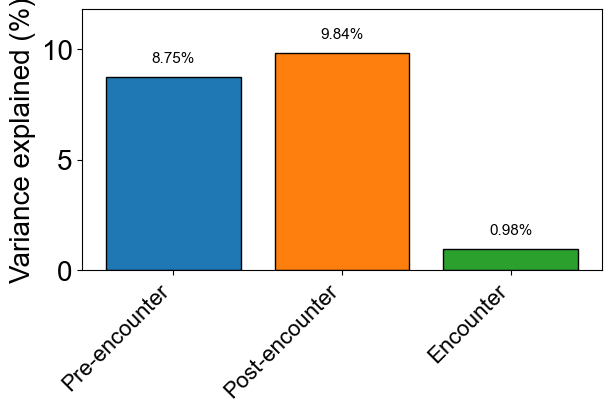

In [211]:
# Plot variance explained bar chart
fig11 = plot_variance_explained(var_explained)
plt.show()

# 10. Data Reconstruction from Coding Directions

Reconstruct the data using projections onto coding directions:
$$\hat{X}(t) = \sum_i \langle X(t), d_i \rangle \cdot d_i$$

This allows us to visualize what each coding direction "captures" and compare reconstruction quality.

In [212]:
# Compute reconstructions from different direction combinations
reconstructions = {}

# Single directions
reconstructions['Pre'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['pre'])
reconstructions['Post'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['post'])
reconstructions['Encounter'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['encounter'])

# Combinations
reconstructions['Pre+Post'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['pre', 'post'])
reconstructions['All'] = reconstruct_from_directions(projections_raw, coding_directions, mask_flat, ['pre', 'post', 'encounter'])

# # Compute reconstruction errors for each
# print("Reconstruction Error Metrics:")
# print("-" * 60)
# for label, recon in reconstructions.items():
#     error = compute_reconstruction_error(g5_flat_for_proj, recon, mask_flat)
#     print(f"{label:15s}  MSE: {error['mse']:.6f}  R²: {error['r_squared']:.4f}  Corr: {error['correlation']:.4f}")

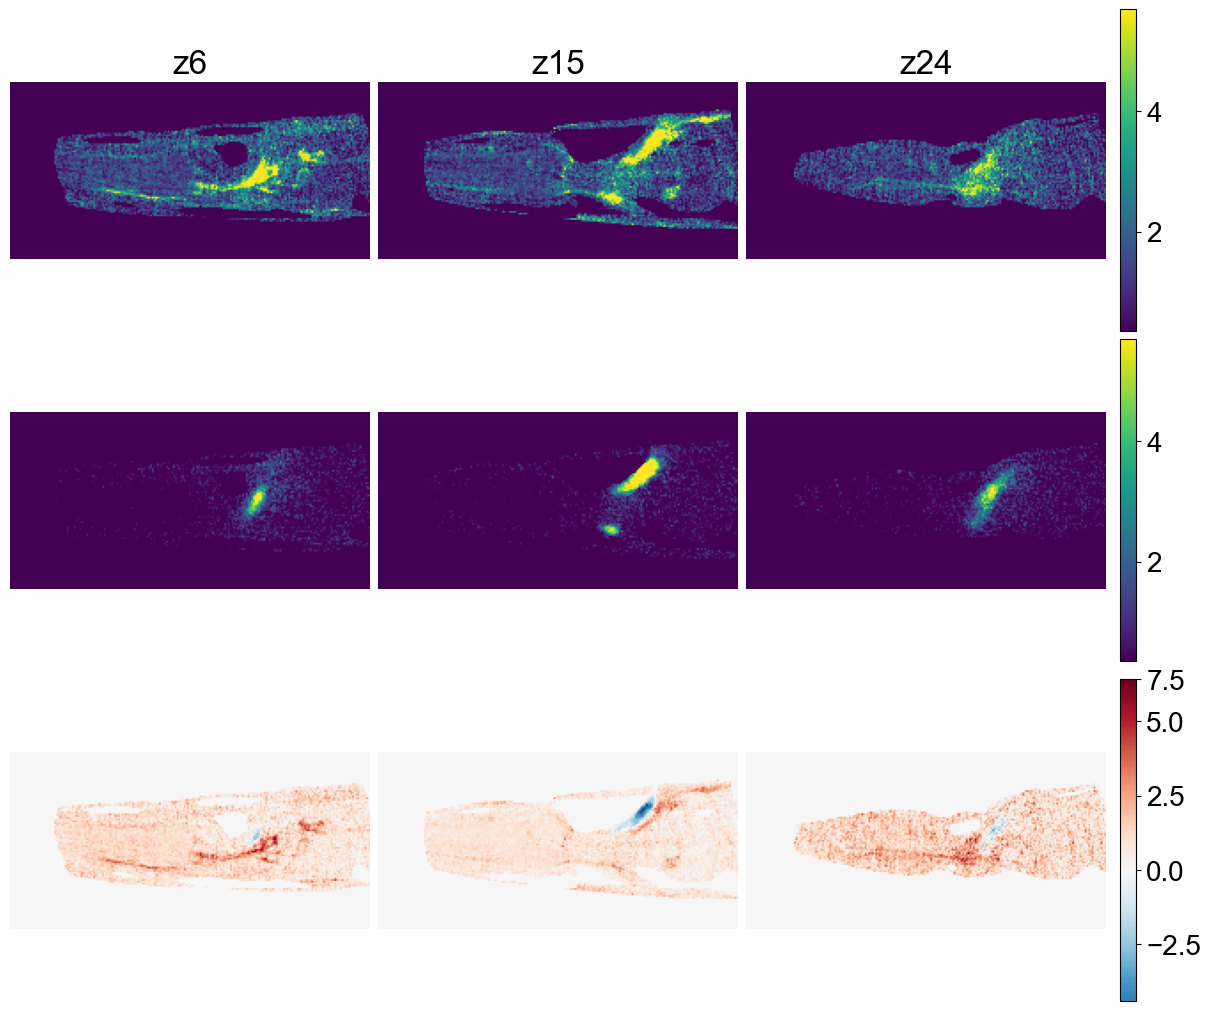

In [216]:
# Plot spatial reconstruction comparison for a single frame
frame_to_reconstruct = 160  # Choose a frame in post-encounter period

fig_recon = plot_reconstruction_spatial(
    g5_4d, reconstructions['Pre'], mask_3d, mask_flat, 
    z_with_roi, frame=frame_to_reconstruct, direction_label="All directions"
)
plt.show()

In [ ]:
# Compare reconstructions from different direction combinations
fig_compare = plot_reconstruction_comparison(
    g5_4d, 
    {'Pre': reconstructions['Pre'], 'Post': reconstructions['Post'], 'All': reconstructions['All']},
    mask_3d, mask_flat, z_with_roi, frame=frame_to_reconstruct
)
plt.show()

In [ ]:
# Plot mean activity time series: original vs reconstructions
fig_ts = plot_reconstruction_timeseries(
    g5_4d, 
    {'Pre': reconstructions['Pre'], 'Post': reconstructions['Post'], 'All': reconstructions['All']},
    mask_flat, config.fps, config
)
plt.show()

In [ ]:
# plot interactive spatial reconstructions

from microfilm.microplot import microshow
from microfilm.microplot import Micropanel
from microfilm.microanim import Microanim
from microfilm.microplot import Microimage
from microfilm.microanim import Microanimpanel

T,Z,H,W = g5_4d.shape
recon = reconstructions['Encounter']
# reshape recon to TZHW
n_total_voxels = Z * H * W
recon_full_flat = np.zeros((T, n_total_voxels), dtype=recon.dtype)
recon_full_flat[:, mask_flat] = recon
recon_reshape = recon_full_flat.reshape(T, Z, H, W)

recon_mip = np.max(recon_reshape, axis=1) # THW

%matplotlib widget

plt.close('all')

mn = 0
mx = 20
fs = 3
dpi = 300


anim = Microanim(
        data=recon_mip[np.newaxis,:,:,:], cmaps=['viridis'], flip_map=False, fig_scaling=fs, dpi=dpi,
        rescale_type='limits', limits=[mn, mx])
anim.add_time_stamp(unit='mmm', unit_per_frame=533, location='upper right')

anim.ui

# 11. Summary and Export

In [ ]:
# Print analysis summary
print("=" * 60)
print("CODING DIRECTIONS ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nConfiguration:")
print(f"  Data path: {config.data_path}")
print(f"  Preprocessing: {config.preprocess_method}")
print(f"  Top N voxels: {config.top_n_voxels or 'all'}")
print(f"  FPS: {config.fps:.3f}")

print(f"\nEpoch Windows (frames):")
print(f"  Baseline:      {config.baseline_window}")
print(f"  Pre-encounter: {config.pre_window}")
print(f"  Post-encounter: {config.post_window}")

print(f"\nData Dimensions:")
print(f"  Original shape: {g5_4d.shape} (T, Z, H, W)")
print(f"  Z slices with ROI: {len(z_with_roi)}")
print(f"  Valid voxels: {np.sum(mask_flat)}")

print(f"\nCoding Direction Similarities:")
sims = coding_directions['similarities']
print(f"  Pre-Post:      {sims['pre_post']:.4f}")
print(f"  Pre-Encounter: {sims['pre_enc']:.4f}")
print(f"  Post-Encounter: {sims['post_enc']:.4f}")

print(f"\nVariance Explained:")
print(f"  Pre-encounter:  {var_explained['pre']*100:.4f}%")
print(f"  Post-encounter: {var_explained['post']*100:.4f}%")
print(f"  Encounter:      {var_explained['encounter']*100:.4f}%")

print(f"\nReconstruction Quality (R²):")
for label, recon in reconstructions.items():
    error = compute_reconstruction_error(g5_flat_for_proj, recon, mask_flat)
    print(f"  {label:15s}: {error['r_squared']*100:.4f}%")
print("=" * 60)

In [ ]:
# Optional: Save results to file
save_results = True  # Set to True to save

if save_results:
    import os
    results_dir = os.path.join(config.data_path, 'coding_directions_results')
    os.makedirs(results_dir, exist_ok=True)
    
    # Save coding directions
    np.save(os.path.join(results_dir, 'pre_coding_direction.npy'), coding_directions['pre'])
    np.save(os.path.join(results_dir, 'post_coding_direction.npy'), coding_directions['post'])
    np.save(os.path.join(results_dir, 'encounter_coding_direction.npy'), coding_directions['encounter'])
    
    # Save projections
    np.save(os.path.join(results_dir, 'projections_pre.npy'), projections_raw['pre'])
    np.save(os.path.join(results_dir, 'projections_post.npy'), projections_raw['post'])
    np.save(os.path.join(results_dir, 'projections_encounter.npy'), projections_raw['encounter'])
    
    # Save variance explained as text
    with open(os.path.join(results_dir, 'variance_explained.txt'), 'w') as f:
        f.write(f"Pre-encounter: {var_explained['pre']*100:.4f}%\n")
        f.write(f"Post-encounter: {var_explained['post']*100:.4f}%\n")
        f.write(f"Encounter: {var_explained['encounter']*100:.4f}%\n")
    
    print(f"Results saved to: {results_dir}")
else:
    print("Set save_results = True to save results to disk.")